In [1]:
from ipynb.fs.full.Utilities import *

In [2]:
# code for custom stop words
stop_words = [x.strip() for x in open('stopWords.txt','r').read().split('\n')]

In [3]:
# loading the dataset
dataset = pd.read_csv("training_set.csv",sep=',',usecols=['tweet','label'])
print(f"Number of tweets: {len(dataset)}")
#display(dataset)

Number of tweets: 906


In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

________________________________________________________________________________
Training:
LinearSVC() with ngram = (1, 1)
Confusion matrix, without normalization
[[166  88  68]
 [ 82 126 114]
 [ 69 101 152]]
{'0': {'precision': 0.5236593059936908, 'recall': 0.515527950310559, 'f1-score': 0.5195618153364632, 'support': 322}, '1': {'precision': 0.4, 'recall': 0.391304347826087, 'f1-score': 0.3956043956043956, 'support': 322}, '2': {'precision': 0.4550898203592814, 'recall': 0.4720496894409938, 'f1-score': 0.46341463414634143, 'support': 322}, 'accuracy': 0.45962732919254656, 'macro avg': {'precision': 0.45958304211765744, 'recall': 0.45962732919254656, 'f1-score': 0.45952694836240005, 'support': 966}, 'weighted avg': {'precision': 0.4595830421176574, 'recall': 0.45962732919254656, 'f1-score': 0.4595269483624001, 'support': 966}, 'time': 0.26945431232452394}
________________________________________________________________________________
Training:
AdaBoostClassifier() with ngram = (1, 1)

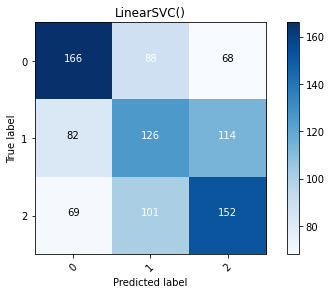

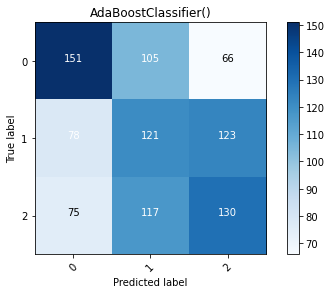

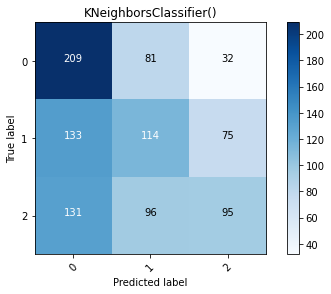

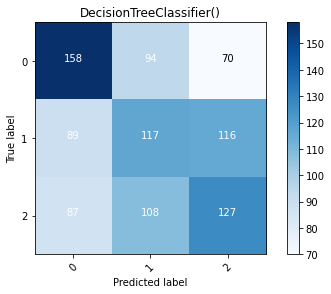

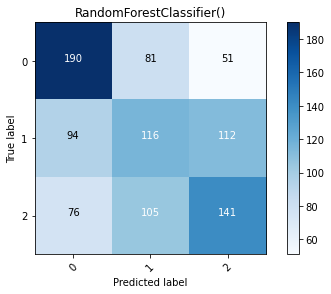

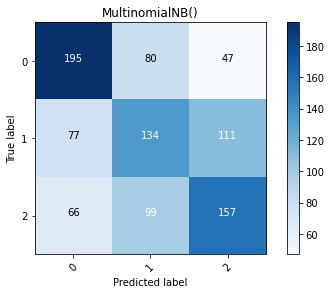

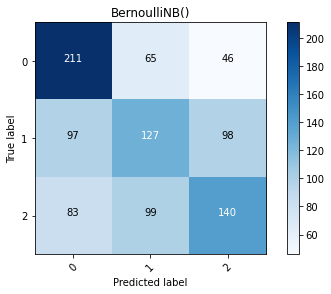

In [9]:
folds = 5;
def benchmark(clf, ngram):
    print('_' * 80)
    print("Training:")
    print(f"{clf} with ngram = {ngram}")
    
    text_clf = Pipeline([
        ('vect', StemmedCountVectorizer(min_df=3, analyzer="word", stop_words = set(stopwords.words('italian')), ngram_range = ngram)),
        #('vect', StemmedCountVectorizer(min_df=3, analyzer="word", stop_words = stop_words, ngram_range = ngram)),
        ('tfidf', TfidfTransformer(smooth_idf=True,use_idf=True)),
        ('clf', clf),
    ])
    
    t0 = time()
    predicted = cross_val_predict(text_clf, dataset.tweet, dataset.label, cv=folds)
    t1 = time()
    t = (t1-t0)/10
    conf_matrix = confusion_matrix(dataset.label, predicted, labels = [0,1,2])
    
    plt.figure()
    plot_confusion_matrix(conf_matrix, classes = [0,1,2], normalize=False, title=f"{clf}")
    
    report = classification_report(dataset.label, predicted, output_dict=True)
    #report["conf_matrix"] = conf_matrix
    report["time"] = t
    print(report)
    output = {}
    output["classifier"] = clf
    output["ngram"] = ngram
    output["scores"] = report
    
    return output

results = []
for clf in (
        (svm.LinearSVC()),
        (AdaBoostClassifier()),
        (KNeighborsClassifier(n_neighbors=5)),
        (DecisionTreeClassifier()),
        (RandomForestClassifier()),
        (MultinomialNB()),
        (BernoulliNB())):
    results.append(benchmark(clf, (1,1)))
    

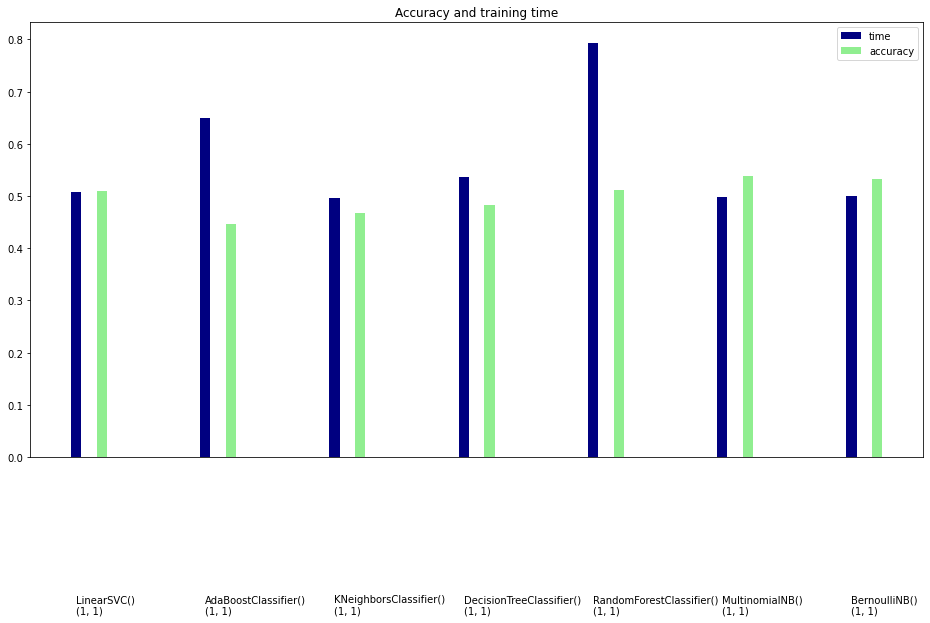

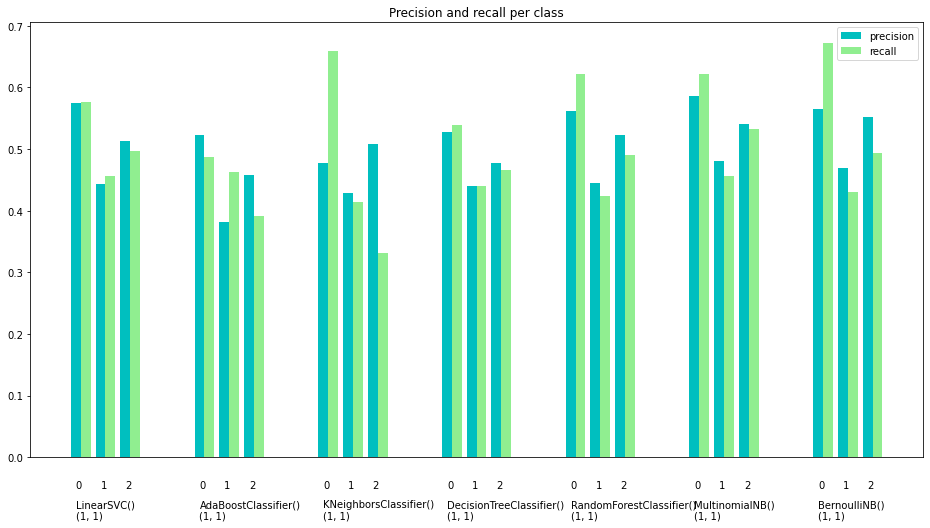

In [22]:
def makeHistogram(results):
    column_size = 0.08
    indices = np.arange(len(results))

    clf_names = [x["classifier"] for x in results]
    ngram = [x["ngram"] for x in results]
    scores = [x["scores"] for x in results]
    #print(scores)
    
    #plotting time and accuracy
    plt.figure(figsize=(16, 8), facecolor="white")
    plt.title("Accuracy and training time")
    plt.bar(indices, [s["time"] for s in scores], column_size, label="time", color='navy')
    plt.bar(indices + .2, [s["accuracy"] for s in scores], column_size, label="accuracy", color='lightgreen')
    plt.xticks(())
    plt.legend(loc='best')
    
    for i, c in zip(indices, clf_names):
        plt.text(i, -.3, str(c) + "\n" + str(ngram[i]))

    plt.show()
    
    #plotting precision and recall scores for each class
    plt.figure(figsize=(16, 8), facecolor="white")
    plt.title("Precision and recall per class")
    
    plt.bar(indices, [s["0"]["precision"] for s in scores], column_size, label="precision", color='c')
    plt.bar(indices + .2, [s["1"]["precision"] for s in scores], column_size, color='c')
    plt.bar(indices +.4, [s["2"]["precision"] for s in scores], column_size, color='c')
    
    plt.bar(indices + .08, [s["0"]["recall"] for s in scores], column_size, label="recall", color='lightgreen')
    plt.bar(indices + .28, [s["1"]["recall"] for s in scores], column_size, color='lightgreen')
    plt.bar(indices + .48, [s["2"]["recall"] for s in scores], column_size, color='lightgreen')
    
    plt.xticks(())
    plt.legend(loc='best')
    
    for i, c in zip(indices, clf_names):
        plt.text(i, -.1, str(c) + "\n" + str(ngram[i]))
        
    for i in indices:
        plt.text(i, -.05, "0")
        plt.text(i + .2, -.05, "1")
        plt.text(i + .4, -.05, "2")

    plt.show()
    
makeHistogram(results)